In [ ]:
import os
from math import ceil 
from time import time
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime
from architectures import *
from data import get_generators, get_dataframe

ts = datetime.fromtimestamp(time()).strftime('%Y-%m-%d-%H-%M-%S')
model, mid = architecture_07()

os.makedirs("./models/MID{mid:03d}_{ts}".format(mid=mid,ts=ts))

tensorboard = TensorBoard(log_dir="./tensorboard/MID{mid:03d}_{ts}".format(mid=mid,ts=ts))
checkpoint = ModelCheckpoint("./models/MID{mid:03d}_{ts}/weights.{{epoch:02d}}-{{val_loss:.2f}}.hdf5".format(mid=mid,ts=ts))
lrchange = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)

df = get_dataframe()
train, validate, test = get_generators(
    df[df["HAS_PICTURE"] & (df["LOG_MEAN_I"] > 0)],
    batch_size=8,
    colorspace="rgb"
)

model.fit_generator(
    train["data"], 
    steps_per_epoch = train["steps"],     
    epochs=50, 
    validation_data=validate["data"], 
    validation_steps=validate["steps"],
    callbacks=[tensorboard, checkpoint, stopper, lrchange]
)

Using TensorFlow backend.


Epoch 1/50
 2009/14187 [===>..........................] - ETA: 4179s - loss: 0.9075 - mean_squared_error: 1.5229

In [18]:
import numpy as np
from math import ceil
from architectures import *
from data import get_generators, get_dataframe

batch_size = 8
n_images = 10000

df = get_dataframe()

train, validate, test = get_generators(
    df[df["HAS_PICTURE"] & (df["LOG_MEAN_I"] > 0)],
    batch_size=batch_size, 
    colorspace="rgb"
)

model, mid = architecture_07()
model.load_weights("./models/MID007_2017-07-14-11-19-05/weights.06-0.37.hdf5")

y_test = np.zeros((n_images,1))
pred_test = np.zeros((n_images,1))
for i in range(0,ceil(n_images/batch_size)):
    features, labels = next(validate["data"])
    y_test[i*batch_size:(i+1)*batch_size,0] = labels
    pred_test[i*batch_size:(i+1)*batch_size,:] = model.predict(features)
    
print(np.max(pred_test))
print(np.min(pred_test))

8.55142307281
5.73152780533


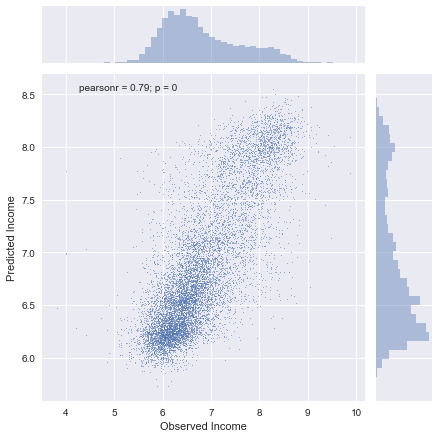

In [20]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(32,32))

from scipy.stats import spearmanr, pearsonr, mode

sns.jointplot(x=y_test,y=pred_test, s=0.2).set_axis_labels("Observed Income","Predicted Income")

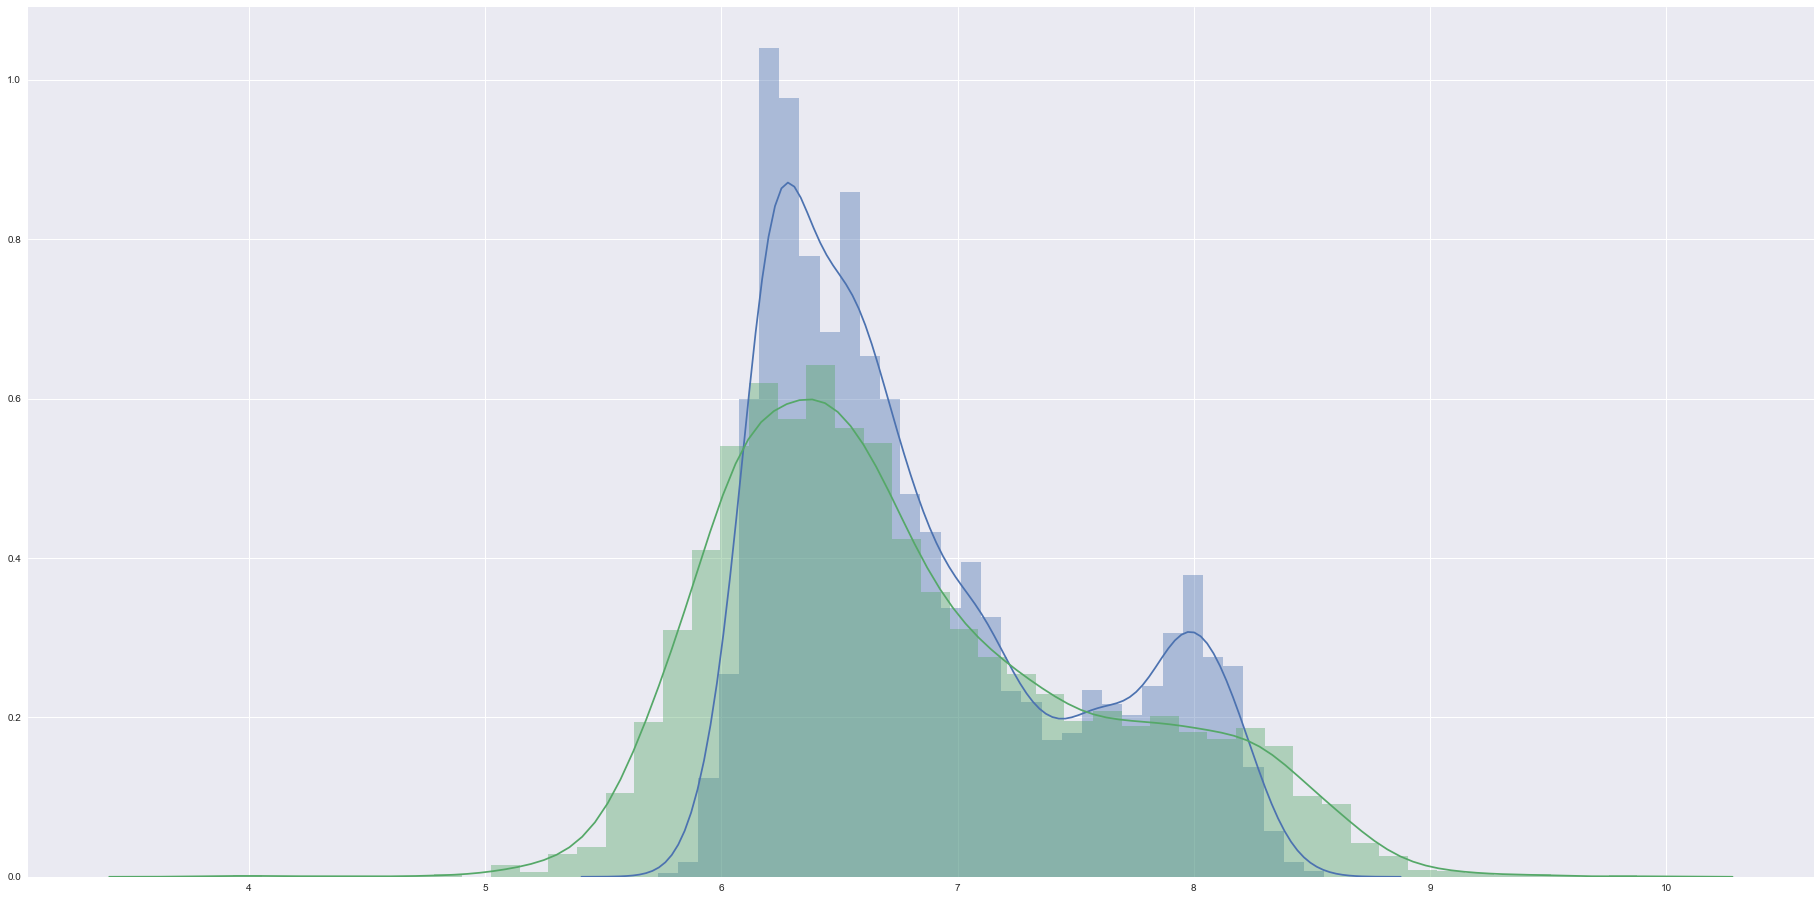

In [22]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(32,16))

error = pred_test - y_test.reshape(-1,1)

sns.distplot(pred_test)
sns.distplot(y_test)

In [ ]:
mode(pred)
problem = np.argwhere(pred == mode(pred))
img = x_test[67,:]
print(mode(pred))
print(pred[67])
plt.imshow((img+0.5)*255)

In [ ]:
sns.distplot(error)

In [23]:
from scipy.stats import mode
from math import exp

max_income = max(pred_test)
min_income = min(pred_test)

print("MAX = ", max_income, exp(max_income))
print("MIN = ", min_income, exp(min_income))

MAX =  [ 8.55142307] 5174.1123291161675
MIN =  [ 5.73152781] 308.4401450789858


In [ ]:
arg_max_income = np.argmax(pred)
arg_min_income = np.argmin(pred)

In [ ]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches((16,8))

ax[0].imshow(x_test[arg_max_income,:]*255)
ax[1].imshow(x_test[arg_min_income,:]*255)

In [ ]:
import os
folder = "./images/streetview512"
for subfolder in os.listdir(folder):
    if len(os.listdir(os.path.join(folder,subfolder))) < 10:
        print(subfolder)